In [1]:
from workshop_utils import * 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import geopandas as gpd
import shapely
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm_notebook as tqdm
tqdm().pandas();

# First, get extract all of the building edits for an area associated with a previous HOT task.


Getting the buildings from task https://tasks.hotosm.org/project/4690 (2018 Ebola)

```sql
SELECT
  subsaharan_africa.id, 
  geom,
  subsaharan_africa.tags, changeset, updated, valid_until, version, minor_version,
  changesets.id AS c_id, 
  changesets.tags as c_tags,
  changesets.uid,
  changesets.user
  
FROM subsaharan_africa

JOIN changesets on subsaharan_africa.changeset = changesets.id

WHERE   
  element_at(subsaharan_africa.tags, 'building') IS NOT NULL AND ST_WITHIN(
  geom , 
  ST_POLYGON('POLYGON((17.8183 0.0461, 18.9637 0.0461, 18.9637 -0.9686, 17.8183 -0.9686, 17.8183 0.0461))'))

ORDER BY updated
```

In [2]:
building_edits = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/ba10a1bb-3347-4c40-a1ae-2f8ff63f344a/csv')

Found file locally... Creating dataframe... done.  Found 133,927 rows

In [3]:
place = "Mbandaka - Bikoro"

In [4]:
building_edits.head(2)

,id,geom,tags,changeset,updated,valid_until,version,minor_version,c_id,c_tags,uid,user
0,205007052,"POLYGON ((18.2499352 0.0439872, 18.2499358 0.0...",{building=yes},14989051,2013-02-11 01:02:26.000,2018-05-12 17:49:31.000,1,0,14989051,"{comment=Drawing buildings (source=Bing), Mban...",190626,clairedelune
1,205007054,"POLYGON ((18.248523 0.0454874, 18.2485153 0.04...",{building=yes},14989051,2013-02-11 01:02:26.000,NaN,1,0,14989051,"{comment=Drawing buildings (source=Bing), Mban...",190626,clairedelune


In [5]:
#Cast the date as date
building_edits['updated'] = building_edits.updated.progress_apply(pd.Timestamp)
building_edits['date'] = building_edits.updated.progress_apply(pd.Timestamp.date)

In [6]:
gb_date = building_edits.groupby('date').aggregate({
    'c_id':'count',
    'id':'nunique',
    'uid':'nunique'
});
gb_date.head(2)

,c_id,id,uid
date,,,
2013-02-11,34,34,1
2013-02-24,39,39,1


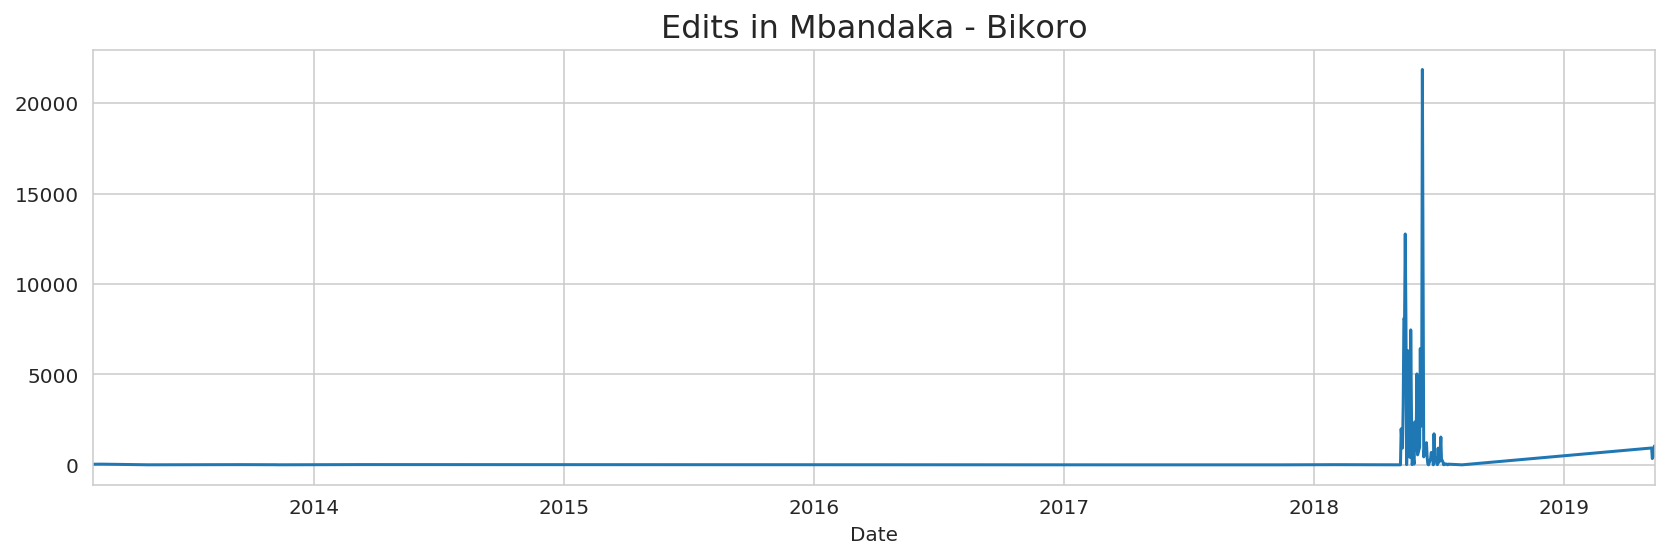

In [7]:
sns.set_style('whitegrid')
ax = gb_date['c_id'].plot(figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Edits in {}".format(place),fontsize=16);

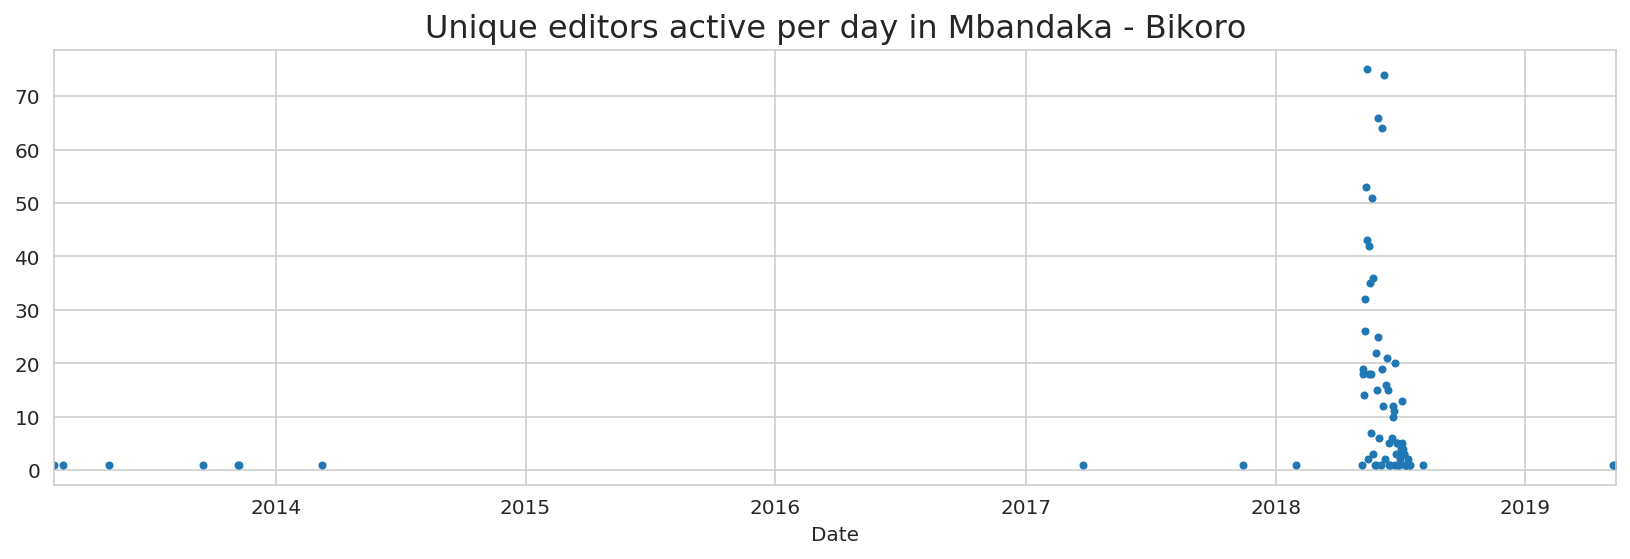

In [8]:
sns.set_style('whitegrid')
ax = gb_date['uid'].plot(style='.', figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Unique editors active per day in {}".format(place),fontsize=16);

In [9]:
from shapely import wkt

In [10]:
building_edits['geom'] = building_edits.geom.progress_apply(wkt.loads) #Makes the geometry an actual object...

In [11]:
objects = gpd.GeoDataFrame(building_edits, geometry='geom')

In [12]:
objects['date'] = objects.updated.apply(lambda x: x.isoformat())

In [13]:
from keplergl import KeplerGl 
map_1 = KeplerGl(height=600)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [14]:
map_1

KeplerGl(height=600)

In [15]:
map_1.add_data(data=objects[objects.updated > datetime.datetime(2018,1,1)][
    r['geom','changeset','date','user','version','minor_version']], name='objects')


### Visualizion

Set layer blending to additive.
and fill color based on minor_version